# NeDF: Neural Distance Fields

## Imports

In [1]:
from dataset import *
from utils import *
from estimate_distance import *
from settings import *
from model import *
from checkpoint import *
from render import *

import numpy as np
import os
import torch
import random
import math
import collections
import statistics

## Load data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
dataset = load_dataset()

In [ ]:
dataset = post_process_dataset(dataset)

## Gradient and loss function

In [5]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

def compute_udf_loss(pred, gt):
    """
    Custom loss for Unoriented Distance Function (UDF).
    - Uses a log-based penalty to avoid predicting 0 everywhere.
    - Keeps standard L1 loss for normal predictions.
    """
    base_loss = torch.nn.functional.l1_loss(pred, gt, reduction='none')

    # Extra penalty when ground truth is close to zero but the prediction is not
    zero_penalty = torch.log1p(torch.abs(pred - gt)) * (gt < 0.05).float()  # Focus on near-zero regions

    return torch.mean(base_loss + zero_penalty)



## Training

In [6]:
def get_debug_query_points(cube_size=2.0, resolution=10, device="cpu"):
    """
    Génère une grille cubique régulière de points en 3D.

    Args:
        cube_size (float): Taille du cube (longueur d'une arête).
        resolution (int): Nombre de points par axe.
        device (str): "cpu" ou "cuda" pour exécuter sur GPU.

    Returns:
        torch.Tensor: Un tenseur de shape (N, 3) contenant les coordonnées 3D des points.
    """
    # Création d'un espace linéaire pour chaque axe (X, Y, Z)
    lin_space = torch.linspace(-cube_size / 2, cube_size / 2, resolution, device=device)

    # Création d'une grille 3D (meshgrid)
    X, Y, Z = torch.meshgrid(lin_space, lin_space, lin_space, indexing="ij")

    # Aplatir la grille en une liste de points 3D
    grid_points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=-1)

    return grid_points  # Shape: (resolution³, 3)

def get_debug_query_points_random(cube_size=2.0, num_points=1000, device="cpu"):
    """
    Génère N points aléatoires à l'intérieur d'un cube 3D.

    Args:
        cube_size (float): Taille du cube (longueur d'une arête).
        num_points (int): Nombre de points à générer.
        device (str): "cpu" ou "cuda" pour exécuter sur GPU.

    Returns:
        torch.Tensor: Un tenseur de shape (N, 3) contenant les coordonnées 3D des points.
    """
    # Générer N points uniformément distribués à l'intérieur du cube
    points = (torch.rand((num_points, 3), device=device) - 0.5) * cube_size  # Centré sur (0,0,0)

    return points  # Shape: (num_points, 3)

In [7]:
# # Learning parameters
# lr = 1e-4

# # Model and optimizer
# model = SimpleUDFModel().to(device)
# model.apply(initialize_weights)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# # Seed RNG
# seed = 9458
# torch.manual_seed(seed)
# np.random.seed(seed)

# # Load previous checkpoint if available
# checkpoint_dir = "checkpoints"
# os.makedirs(checkpoint_dir, exist_ok=True)
# start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, CHECKPOINT_NAME))

In [8]:
# # Training parameters
# save_every = 500  # Save every n iterations

# num_iters = start_epoch + 500000 # Change this here for longer sessions

# ray_range = 10 # Range of the rays
# num_viewpoints = 10 # Number of viewpoints used per batch
# num_rays = 1024 * 8  # Number of rays to be tested per batch
# num_samples_per_ray = 25 # Numver of samples per ray

# loss_buffer = collections.deque(maxlen=100)

# # Training Loop
# for i in range(start_epoch, num_iters):
#     # Étape 1: Sélectionner aléatoirement 10 entrées du dataset
#     # dataset_indices = torch.randint(0, len(dataset), (num_viewpoints,))
#     # selected_entries = [list(dataset.values())[idx] for idx in dataset_indices.cpu().numpy()]

#     # # Étape 2: Aplatir les entrées sélectionnées en un seul tenseur
#     # target_depth = torch.cat([torch.tensor(data[FILTERED_DEPTH_MAP_ENTRY], dtype=torch.float32) for data in selected_entries]).to(device)
#     # ray_directions = torch.cat([torch.tensor(data[FILTERED_RAY_DIRECTIONS_ENTRY], dtype=torch.float32) for data in selected_entries]).to(device)

#     # # Étape 3: Sélectionner un échantillon aléatoire de `num_rays` dans ces tenseurs aplatis
#     # rand_indices = torch.randint(0, target_depth.shape[0], (num_rays,))
#     # selected_depth = target_depth[rand_indices]
#     # selected_rays = ray_directions[rand_indices]

#     # # Génération de N points aléatoires le long de chaque rayon
#     # rand_samples = torch.rand((num_rays, num_samples_per_ray), device=device) * ray_range  # Échantillonnage uniforme
#     # ray_points = selected_rays.unsqueeze(1) * rand_samples.unsqueeze(-1)  # Multiplication direction * distance
#     # query_points = ray_points.view(-1, 3)  # Aplatir en une liste de points 3D
#     # query_points = get_debug_query_points(cube_size=7.5, resolution=50, device=device)
#     query_points = get_debug_query_points_random(cube_size=7.5, num_points=1, device=device)
#     # query_points = torch.tensor([[0, 5.0, 0]], device=device)

#     # Find correct distances
#     estimated_distances = estimate_distances(query_points, dataset, device, False)
#     predicted_distances = model(query_points).squeeze(-1 )

#     # Combine Losses
#     gradients = compute_gradients(model, query_points, sample_ratio=1)
#     eikonal_loss = compute_eikonal_loss(gradients)

#     distance_loss = torch.nn.functional.mse_loss(predicted_distances, estimated_distances)
#     # distance_loss = compute_udf_loss(pred=predicted_distances, gt=estimated_distances)

#     loss = distance_loss
#     loss_buffer.append(loss.item())
#     mean_loss = sum(loss_buffer) / len(loss_buffer)
#     median_loss = statistics.median(loss_buffer)

#     print(f"Iteration {i}: Median Loss (Last 100): {median_loss:.4f}, Mean Loss (Last 100): {mean_loss}, Current Loss: {distance_loss.item():.4f}")

#     # Backpropagation
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # Save checkpoint periodically or if loss improves
#     if i % save_every == 0 or loss.item() < best_loss:
#         if loss.item() < best_loss:
#             best_loss = loss.item()
#         save_checkpoint(model, optimizer, i, loss.item(), os.path.join(checkpoint_dir, CHECKPOINT_NAME))

# print("Training complete!")

## Inference

In [124]:
lr = 1e-5

# Model and optimizer
model = SimpleUDFModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Load checkpoint
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
start_epoch, best_loss = load_checkpoint(model, optimizer, os.path.join(checkpoint_dir, CHECKPOINT_NAME))

Loaded checkpoint from checkpoints\checkpoint.pth: Epoch 1413500, Loss: 1.6009


c:\Users\Alex\Git\NeDF\transforms\checkpoint.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


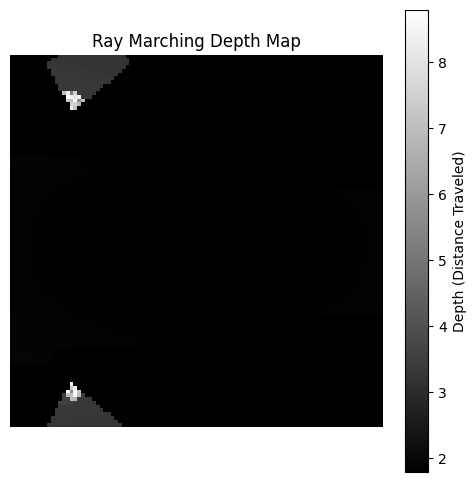

In [ ]:
import matplotlib.pyplot as plt

position = torch.tensor([0.0, 0.0, -7.0])  # Camera position
projection_matrix = dataset[0][CAMERA_PROJECTION_ENTRY]

rays = generate_rays_from_projection(position, -179, 0, 0, projection_matrix, device=device)
depth_map = march_rays(model, rays, position, num_samples=50, threshold=0.01, max_distance=10.0, device=device)

depth_map_reshaped = depth_map.reshape(100, 100).cpu().detach().numpy()

# Plot depth map
plt.figure(figsize=(6, 6))
plt.imshow(depth_map_reshaped, cmap="grey", interpolation="nearest")
plt.colorbar(label="Depth (Distance Traveled)")
plt.title("Ray Marching Depth Map")
plt.axis("off")
plt.show()